In [3]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import tqdm
from torch.utils.data.dataset import Dataset
import glob
import pickle
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

%matplotlib inline
%config InlineBackend.figure_format = "retina"

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


## **Latent Diffusion Models**

### The idea is to train the diffusion models on a low dimensional latent representation rather than the entire big pixel space. In addition to that, also train an Encoder-Decoder model that takes the original image converts it into the latent representation using the encoder and reconverts the latent representation to the reconstructed image.

<p align="center">
<img src="./Media/Latent2.png" style="width:60%;border:0;" alt = "image">
</p>

### The downside is that although the $L1/L2$ reconstruction loss might be low, the perceptual features in the reconstructed image still might be **fuzzy**

## Perceptual Retention & $\text{LPIPS}$ as the metric

<p align="center">
<img src="./Media/Percept.png" style="width:80%;border:0;" alt = "image">
</p>

CLearly as said that although the $L_1$ or $L_2$ reconstruction loss might be low for the image, yet the perceptual features in the image perceived by a human are still **blurry**. Now in order to understand how a model would perceive the image, there is no better place to dig into pretrained classification **CNNs** $\to$ **VGGs**. The goal is to bring the feature map extracted at each VGG layer to be very similar to the original image's feature maps at each VGG layer. This distance metric between the feature maps extracted from the layers of a pretrained VGG is called the **perceptual loss**.

<p align="center">
<img src="./Media/LPIPS1.png" style="width:80%;border:0;" alt = "image">
</p>

Check out the original implementation too at [Perceptual Similarity](https://github.com/richzhang/PerceptualSimilarity).

In [4]:
# lpips.py implementation
from collections import namedtuple

def spatial_average(in_tens, keepdim = True):
    return in_tens.mean([2, 3], keepdim = keepdim)


class vgg16(nn.Module):
    def __init__(self, requires_grad = False, pretrained = True):
        super().__init__()
        vgg_pretrained_features = models.vgg16(pretrained = pretrained).features
        self.slice1 = nn.Sequential()
        self.slice2 = nn.Sequential()
        self.slice3 = nn.Sequential()
        self.slice4 = nn.Sequential()
        self.slice5 = nn.Sequential()
        self.N_slices = 5
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
            
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        
        for x in range(23, 30):
            self.slice5.add_module(str(x), vgg_pretrained_features[x])
        
        # Freeze the model
        if requires_grad == False:
            for param in self.parameters():
                param.requires_grad = False
    
    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        h = self.slice5(h)
        h_relu5_3 = h
        vgg_outputs = namedtuple("VggOutputs", ["relu1_2", "relu2_2", "relu3_3", "relu4_3", "relu5_3"])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3, h_relu5_3)
        return out
    
    
class ScalingLayer(nn.Module):
    def __init__(self):
        super().__init__()
        # mean = [0.485, 0.456, 0.406]
        # std = [0.229, 0.224, 0.225]
        self.register_buffer("shift", torch.tensor([-.030, -.088, -.188])[None, :, None, None])
        self.register_buffer("scale", torch.tensor([.458, .448, .450])[None, :, None, None])
    
    def forward(self, inp):
        return (inp - self.shift) / self.scale

class NetLinLayer(nn.Module):
    def __init__(self, chn_in, chn_out = 1, use_dropout = False):
        super().__init__()
        
        layers = [nn.Dropout(), ] if (use_dropout) else []
        layers += [nn.Conv2d(chn_in, chn_out, kernel_size = 1, stride = 1, padding = 0, bias = False), ]
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

class LPIPS(nn.Module):
    def __init__(self, use_dropout = True):
        super().__init__()
        self.scaling_layer = ScalingLayer()
        
        self.chns = [64, 128, 256, 512, 512]
        self.L = len(self.chns)
        self.net = vgg16(pretrained = True, requires_grad = False)
        
        self.lin0 = NetLinLayer(self.chns[0], use_dropout = use_dropout)
        self.lin1 = NetLinLayer(self.chns[1], use_dropout = use_dropout)
        self.lin2 = NetLinLayer(self.chns[2], use_dropout = use_dropout)
        self.lin3 = NetLinLayer(self.chns[3], use_dropout = use_dropout)
        self.lin4 = NetLinLayer(self.chns[4], use_dropout = use_dropout)
        self.lins = [self.lin0, self.lin1, self.lin2, self.lin3, self.lin4]
        self.lins = nn.ModuleList(self.lins)
        
        self.net.load_state_dict(torch.load("./vgg.pth", map_location = device), strict = False)
        
        self.eval()
        
        for param in self.parameters():
            param.requires_grad = False
        
    
    def forward(self, in0, in1, normalize = False):
        if normalize:
            in0 = 2 * in0 - 1
            in1 = 2 * in1 - 1
        
        in0_input, in1_input = self.scaling_layer(in0), self.scaling_layer(in1)
        
        outs0, outs1 = self.net.forward(in0_input), self.net.forward(in1_input)
        
        feats0, feats1, diffs = {}, {}, {}
        
        for kk in range(self.L):
            feats0[kk], feats1[kk] = F.normalize(outs0[kk], dim = 1), F.normalize(outs1[kk])
            diffs[kk] = (feats0[kk] - feats1[kk]) ** 2
        
        res = [spatial_average(self.lins[kk](diffs[kk]), keepdim = True) for kk in range(self.L)]
        val = 0
        
        for l in range(self.L):
            val += res[l]
        
        return val

## Discretizing the Latent Space using the $\text{CodeBooks}$ from $\text{VQVAEs}$
### $\text{VQVAE}$ as the $\text{AutoEncoder}$

$k$ vectors, each of $d$ dimensions $(k \times d)$ help us encode the data.

<p align="center">
<img src="./Media/VQVAE1.png" style="width:70%;border:0;" alt = "image">
</p>

The encoder generates a feature map of $H \times W$ features each of $d$ dimension.
<p align="center">
<img src="./Media/VQVAE2.png" style="width:70%;border:0;" alt = "image">
</p>

For each of the features, we find the nearest $d$ dimensional encoding to it and replace it with that.

$$ z_q(x) = e_k $$
$$ k = \argmin_j || z_e(x) - e_j ||_2 $$

<p align="center">
<img src="./Media/VQVAE3.png" style="width:70%;border:0;" alt = "image">
</p>

The decoder then discards off the feature map given by the encoder and only uses the nearest codeblock feature map to reconstruct the output image.
<p align="center">
<img src="./Media/VQVAE4.png" style="width:70%;border:0;" alt = "image">
</p>

The issue is we have to define the gradients for the $\argmin$ step separately for the gradients to flow back. We approximate the gradient similar to the straight-through estimator and just copy gradients from decoder input $z_q(x)$ to encoder output $z_e(x)$
<p align="center">
<img src="./Media/VQVAE5.png" style="width:70%;border:0;" alt = "image">
</p>

$$ L = \log p(x | z_q(x)) + || \text{sg}[z_e(x)] - e ||_2^2 + \beta || z_e(x) - \text{sg}[e] ||_2^2 $$

## The AutoEncoder Architecture

<p align="center">
<img src="./Media/Latent3.png" style="width:80%;border:0;" alt = "image">
</p>

<p align="center">
<img src="./Media/Latent4.png" style="width:80%;border:0;" alt = "image">
</p>

<p align="center">
<img src="./Media/AutoEnc1.png" style="width:80%;border:0;" alt = "image">
</p>

<p align="center">
<img src="./Media/AutoEnc2.png" style="width:80%;border:0;" alt = "image">
</p>

<p align="center">
<img src="./Media/AutoEnc3.png" style="width:80%;border:0;" alt = "image">
</p>

<p align="center">
<img src="./Media/AutoEnc4.png" style="width:80%;border:0;" alt = "image">
</p>

### The Model Blocks
Adapted from [ExplainingAI](https://github.com/explainingai-code/StableDiffusion-PyTorch/blob/main/models/blocks.py)

In [5]:
# Time Embedding

def get_time_embedding(T, d_model):
    factor = 10000 ** ((torch.arange(start = 0, end = d_model // 2, dtype = torch.float32, device = T.device)) / (d_model // 2))
    t_emb = T[:, None].repeat(1, d_model // 2) / factor
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim = -1)
    return t_emb


# Model Blocks

class DownBlock(nn.Module):
    r"""
    Down conv block with attention.
    Sequence of following block
    1. Resnet block with time embedding
    2. Attention block
    3. Downsample
    """
    
    def __init__(self, in_channels, out_channels, t_emb_dim,
                 down_sample, num_heads, num_layers, attn, norm_channels, cross_attn=False, context_dim=None):
        super().__init__()
        self.num_layers = num_layers
        self.down_sample = down_sample
        self.attn = attn
        self.context_dim = context_dim
        self.cross_attn = cross_attn
        self.t_emb_dim = t_emb_dim
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels,
                              kernel_size=3, stride=1, padding=1),
                )
                for i in range(num_layers)
            ]
        )
        if self.t_emb_dim is not None:
            self.t_emb_layers = nn.ModuleList([
                nn.Sequential(
                    nn.SiLU(),
                    nn.Linear(self.t_emb_dim, out_channels)
                )
                for _ in range(num_layers)
            ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels,
                              kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
        
        if self.attn:
            self.attention_norms = nn.ModuleList(
                [nn.GroupNorm(norm_channels, out_channels)
                 for _ in range(num_layers)]
            )
            
            self.attentions = nn.ModuleList(
                [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                 for _ in range(num_layers)]
            )
        
        if self.cross_attn:
            assert context_dim is not None, "Context Dimension must be passed for cross attention"
            self.cross_attention_norms = nn.ModuleList(
                [nn.GroupNorm(norm_channels, out_channels)
                 for _ in range(num_layers)]
            )
            self.cross_attentions = nn.ModuleList(
                [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                 for _ in range(num_layers)]
            )
            self.context_proj = nn.ModuleList(
                [nn.Linear(context_dim, out_channels)
                 for _ in range(num_layers)]
            )

        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.down_sample_conv = nn.Conv2d(out_channels, out_channels,
                                          4, 2, 1) if self.down_sample else nn.Identity()
    
    def forward(self, x, t_emb=None, context=None):
        out = x
        for i in range(self.num_layers):
            # Resnet block of Unet
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            if self.t_emb_dim is not None:
                out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)
            
            if self.attn:
                # Attention block of Unet
                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
                out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn
            
            if self.cross_attn:
                assert context is not None, "context cannot be None if cross attention layers are used"
                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.cross_attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                assert context.shape[0] == x.shape[0] and context.shape[-1] == self.context_dim
                context_proj = self.context_proj[i](context)
                out_attn, _ = self.cross_attentions[i](in_attn, context_proj, context_proj)
                out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn
            
        # Downsample
        out = self.down_sample_conv(out)
        return out


class MidBlock(nn.Module):
    r"""
    Mid conv block with attention.
    Sequence of following blocks
    1. Resnet block with time embedding
    2. Attention block
    3. Resnet block with time embedding
    """
    
    def __init__(self, in_channels, out_channels, t_emb_dim, num_heads, num_layers, norm_channels, cross_attn=None, context_dim=None):
        super().__init__()
        self.num_layers = num_layers
        self.t_emb_dim = t_emb_dim
        self.context_dim = context_dim
        self.cross_attn = cross_attn
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers + 1)
            ]
        )
        
        if self.t_emb_dim is not None:
            self.t_emb_layers = nn.ModuleList([
                nn.Sequential(
                    nn.SiLU(),
                    nn.Linear(t_emb_dim, out_channels)
                )
                for _ in range(num_layers + 1)
            ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers + 1)
            ]
        )
        
        self.attention_norms = nn.ModuleList(
            [nn.GroupNorm(norm_channels, out_channels)
             for _ in range(num_layers)]
        )
        
        self.attentions = nn.ModuleList(
            [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
             for _ in range(num_layers)]
        )
        if self.cross_attn:
            assert context_dim is not None, "Context Dimension must be passed for cross attention"
            self.cross_attention_norms = nn.ModuleList(
                [nn.GroupNorm(norm_channels, out_channels)
                 for _ in range(num_layers)]
            )
            self.cross_attentions = nn.ModuleList(
                [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                 for _ in range(num_layers)]
            )
            self.context_proj = nn.ModuleList(
                [nn.Linear(context_dim, out_channels)
                 for _ in range(num_layers)]
            )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers + 1)
            ]
        )
    
    def forward(self, x, t_emb=None, context=None):
        out = x
        
        # First resnet block
        resnet_input = out
        out = self.resnet_conv_first[0](out)
        if self.t_emb_dim is not None:
            out = out + self.t_emb_layers[0](t_emb)[:, :, None, None]
        out = self.resnet_conv_second[0](out)
        out = out + self.residual_input_conv[0](resnet_input)
        
        for i in range(self.num_layers):
            # Attention Block
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn
            
            if self.cross_attn:
                assert context is not None, "context cannot be None if cross attention layers are used"
                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.cross_attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                assert context.shape[0] == x.shape[0] and context.shape[-1] == self.context_dim
                context_proj = self.context_proj[i](context)
                out_attn, _ = self.cross_attentions[i](in_attn, context_proj, context_proj)
                out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn
                
            
            # Resnet Block
            resnet_input = out
            out = self.resnet_conv_first[i + 1](out)
            if self.t_emb_dim is not None:
                out = out + self.t_emb_layers[i + 1](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i + 1](out)
            out = out + self.residual_input_conv[i + 1](resnet_input)
        
        return out


class UpBlock(nn.Module):
    r"""
    Up conv block with attention.
    Sequence of following blocks
    1. Upsample
    1. Concatenate Down block output
    2. Resnet block with time embedding
    3. Attention Block
    """
    
    def __init__(self, in_channels, out_channels, t_emb_dim,
                 up_sample, num_heads, num_layers, attn, norm_channels):
        super().__init__()
        self.num_layers = num_layers
        self.up_sample = up_sample
        self.t_emb_dim = t_emb_dim
        self.attn = attn
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers)
            ]
        )
        
        if self.t_emb_dim is not None:
            self.t_emb_layers = nn.ModuleList([
                nn.Sequential(
                    nn.SiLU(),
                    nn.Linear(t_emb_dim, out_channels)
                )
                for _ in range(num_layers)
            ])
        
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
        if self.attn:
            self.attention_norms = nn.ModuleList(
                [
                    nn.GroupNorm(norm_channels, out_channels)
                    for _ in range(num_layers)
                ]
            )
            
            self.attentions = nn.ModuleList(
                [
                    nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                    for _ in range(num_layers)
                ]
            )
            
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.up_sample_conv = nn.ConvTranspose2d(in_channels, in_channels,
                                                 4, 2, 1) \
            if self.up_sample else nn.Identity()
    
    def forward(self, x, out_down=None, t_emb=None):
        # Upsample
        x = self.up_sample_conv(x)
        
        # Concat with Downblock output
        if out_down is not None:
            x = torch.cat([x, out_down], dim=1)
        
        out = x
        for i in range(self.num_layers):
            # Resnet Block
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            if self.t_emb_dim is not None:
                out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)
            
            # Self Attention
            if self.attn:
                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
                out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn
        return out


class UpBlockUnet(nn.Module):
    r"""
    Up conv block with attention.
    Sequence of following blocks
    1. Upsample
    1. Concatenate Down block output
    2. Resnet block with time embedding
    3. Attention Block
    """
    
    def __init__(self, in_channels, out_channels, t_emb_dim, up_sample,
                 num_heads, num_layers, norm_channels, cross_attn=False, context_dim=None):
        super().__init__()
        self.num_layers = num_layers
        self.up_sample = up_sample
        self.t_emb_dim = t_emb_dim
        self.cross_attn = cross_attn
        self.context_dim = context_dim
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers)
            ]
        )
        
        if self.t_emb_dim is not None:
            self.t_emb_layers = nn.ModuleList([
                nn.Sequential(
                    nn.SiLU(),
                    nn.Linear(t_emb_dim, out_channels)
                )
                for _ in range(num_layers)
            ])
            
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
        
        self.attention_norms = nn.ModuleList(
            [
                nn.GroupNorm(norm_channels, out_channels)
                for _ in range(num_layers)
            ]
        )
        
        self.attentions = nn.ModuleList(
            [
                nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                for _ in range(num_layers)
            ]
        )
        
        if self.cross_attn:
            assert context_dim is not None, "Context Dimension must be passed for cross attention"
            self.cross_attention_norms = nn.ModuleList(
                [nn.GroupNorm(norm_channels, out_channels)
                 for _ in range(num_layers)]
            )
            self.cross_attentions = nn.ModuleList(
                [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                 for _ in range(num_layers)]
            )
            self.context_proj = nn.ModuleList(
                [nn.Linear(context_dim, out_channels)
                 for _ in range(num_layers)]
            )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.up_sample_conv = nn.ConvTranspose2d(in_channels // 2, in_channels // 2,
                                                 4, 2, 1) \
            if self.up_sample else nn.Identity()
    
    def forward(self, x, out_down=None, t_emb=None, context=None):
        x = self.up_sample_conv(x)
        if out_down is not None:
            x = torch.cat([x, out_down], dim=1)
        
        out = x
        for i in range(self.num_layers):
            # Resnet
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            if self.t_emb_dim is not None:
                out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)
            # Self Attention
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn
            # Cross Attention
            if self.cross_attn:
                assert context is not None, "context cannot be None if cross attention layers are used"
                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.cross_attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                assert len(context.shape) == 3, \
                    "Context shape does not match B,_,CONTEXT_DIM"
                assert context.shape[0] == x.shape[0] and context.shape[-1] == self.context_dim,\
                    "Context shape does not match B,_,CONTEXT_DIM"
                context_proj = self.context_proj[i](context)
                out_attn, _ = self.cross_attentions[i](in_attn, context_proj, context_proj)
                out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn
        
        return out

### VQVAE Implementation

In [6]:
class VQVAE(nn.Module):
    def __init__(self):
        super().__init__()
        im_channels = 3
        self.down_channels = [64, 128, 256, 256]
        self.mid_channels = [256, 256]
        self.down_sample = [True, True, True]
        self.num_down_layers = 2
        self.num_mid_layers = 2
        self.num_up_layers = 2
        self.norm_channels = 32
        
        # To disable attention in the DownBlock of Encoder and UpBlock of Decoder
        self.attns = [False, False, False]
        self.num_heads = 4
        
        # Latent Dimension
        self.z_channels = 3
        self.codebook_size = 8192
        
        # Wherever we use downsampling in encoder correspondingly use
        # upsampling in decoder
        self.up_sample = list(reversed(self.down_sample))
        
        ##################### Encoder ######################
        self.encoder_conv_in = nn.Conv2d(im_channels, self.down_channels[0], kernel_size=3, padding=(1, 1))
        
        # Downblock + Midblock
        self.encoder_layers = nn.ModuleList([])
        for i in range(len(self.down_channels) - 1):
            self.encoder_layers.append(DownBlock(self.down_channels[i], self.down_channels[i + 1],
                                                 t_emb_dim=None, down_sample=self.down_sample[i],
                                                 num_heads=self.num_heads,
                                                 num_layers=self.num_down_layers,
                                                 attn=self.attns[i],
                                                 norm_channels=self.norm_channels))
        
        self.encoder_mids = nn.ModuleList([])
        for i in range(len(self.mid_channels) - 1):
            self.encoder_mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i + 1],
                                              t_emb_dim=None,
                                              num_heads=self.num_heads,
                                              num_layers=self.num_mid_layers,
                                              norm_channels=self.norm_channels))
        
        self.encoder_norm_out = nn.GroupNorm(self.norm_channels, self.down_channels[-1])
        self.encoder_conv_out = nn.Conv2d(self.down_channels[-1], self.z_channels, kernel_size=3, padding=1)
        
        # Pre Quantization Convolution
        self.pre_quant_conv = nn.Conv2d(self.z_channels, self.z_channels, kernel_size=1)
        
        # Codebook
        self.embedding = nn.Embedding(self.codebook_size, self.z_channels)
        ####################################################
        
        ##################### Decoder ######################
        
        # Post Quantization Convolution
        self.post_quant_conv = nn.Conv2d(self.z_channels, self.z_channels, kernel_size=1)
        self.decoder_conv_in = nn.Conv2d(self.z_channels, self.mid_channels[-1], kernel_size=3, padding=(1, 1))
        
        # Midblock + Upblock
        self.decoder_mids = nn.ModuleList([])
        for i in reversed(range(1, len(self.mid_channels))):
            self.decoder_mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i - 1],
                                              t_emb_dim=None,
                                              num_heads=self.num_heads,
                                              num_layers=self.num_mid_layers,
                                              norm_channels=self.norm_channels))
        
        self.decoder_layers = nn.ModuleList([])
        for i in reversed(range(1, len(self.down_channels))):
            self.decoder_layers.append(UpBlock(self.down_channels[i], self.down_channels[i - 1],
                                               t_emb_dim=None, up_sample=self.down_sample[i - 1],
                                               num_heads=self.num_heads,
                                               num_layers=self.num_up_layers,
                                               attn=self.attns[i-1],
                                               norm_channels=self.norm_channels))
        
        self.decoder_norm_out = nn.GroupNorm(self.norm_channels, self.down_channels[0])
        self.decoder_conv_out = nn.Conv2d(self.down_channels[0], im_channels, kernel_size=3, padding=1)
    
    def quantize(self, x):
        B, C, H, W = x.shape
        
        # B, C, H, W -> B, H, W, C
        x = x.permute(0, 2, 3, 1)
        
        # B, H, W, C -> B, H*W, C
        x = x.reshape(x.size(0), -1, x.size(-1))
        
        # Find nearest embedding/codebook vector
        # dist between (B, H*W, C) and (B, K, C) -> (B, H*W, K)
        dist = torch.cdist(x, self.embedding.weight[None, :].repeat((x.size(0), 1, 1)))
        # (B, H*W)
        min_encoding_indices = torch.argmin(dist, dim=-1)
        
        # Replace encoder output with nearest codebook
        # quant_out -> B*H*W, C
        quant_out = torch.index_select(self.embedding.weight, 0, min_encoding_indices.view(-1))
        
        # x -> B*H*W, C
        x = x.reshape((-1, x.size(-1)))
        commmitment_loss = torch.mean((quant_out.detach() - x) ** 2)
        codebook_loss = torch.mean((quant_out - x.detach()) ** 2)
        quantize_losses = {
            'codebook_loss': codebook_loss,
            'commitment_loss': commmitment_loss
        }
        # Straight through estimation
        quant_out = x + (quant_out - x).detach()
        
        # quant_out -> B, C, H, W
        quant_out = quant_out.reshape((B, H, W, C)).permute(0, 3, 1, 2)
        min_encoding_indices = min_encoding_indices.reshape((-1, quant_out.size(-2), quant_out.size(-1)))
        return quant_out, quantize_losses, min_encoding_indices

    def encode(self, x):
        out = self.encoder_conv_in(x)
        for idx, down in enumerate(self.encoder_layers):
            out = down(out)
        for mid in self.encoder_mids:
            out = mid(out)
        out = self.encoder_norm_out(out)
        out = nn.SiLU()(out)
        out = self.encoder_conv_out(out)
        out = self.pre_quant_conv(out)
        out, quant_losses, _ = self.quantize(out)
        return out, quant_losses
    
    def decode(self, z):
        out = z
        out = self.post_quant_conv(out)
        out = self.decoder_conv_in(out)
        for mid in self.decoder_mids:
            out = mid(out)
        for idx, up in enumerate(self.decoder_layers):
            out = up(out)
        
        out = self.decoder_norm_out(out)
        out = nn.SiLU()(out)
        out = self.decoder_conv_out(out)
        return out
    
    def forward(self, x):
        z, quant_losses = self.encode(x)
        out = self.decode(z)
        return out, z, quant_losses

### Discriminator

In [7]:
class Discriminator(nn.Module):
    r"""
    PatchGAN Discriminator.
    Rather than taking IMG_CHANNELSxIMG_HxIMG_W all the way to
    1 scalar value , we instead predict grid of values.
    Where each grid is prediction of how likely
    the discriminator thinks that the image patch corresponding
    to the grid cell is real
    """
    
    def __init__(self, im_channels=3,
                 conv_channels=[64, 128, 256],
                 kernels=[4,4,4,4],
                 strides=[2,2,2,1],
                 paddings=[1,1,1,1]):
        super().__init__()
        self.im_channels = im_channels
        activation = nn.LeakyReLU(0.2)
        layers_dim = [self.im_channels] + conv_channels + [1]
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(layers_dim[i], layers_dim[i + 1],
                          kernel_size=kernels[i],
                          stride=strides[i],
                          padding=paddings[i],
                          bias=False if i !=0 else True),
                nn.BatchNorm2d(layers_dim[i + 1]) if i != len(layers_dim) - 2 and i != 0 else nn.Identity(),
                activation if i != len(layers_dim) - 2 else nn.Identity()
            )
            for i in range(len(layers_dim) - 1)
        ])
    
    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out

## Loading Dataset - CelebAHQ

In [8]:
def load_latents(latent_path):
    r"""
    Simple utility to save latents to speed up ldm training
    :param latent_path:
    :return:
    """
    latent_maps = {}
    for fname in glob.glob(os.path.join(latent_path, '*.pkl')):
        s = pickle.load(open(fname, 'rb'))
        for k, v in s.items():
            latent_maps[k] = v[0]
    return latent_maps

class CelebDataset(Dataset):
    r"""
    Celeb dataset will by default centre crop and resize the images.
    This can be replaced by any other dataset. As long as all the images
    are under one directory.
    """
    
    def __init__(self, split, im_path, im_size=256, im_channels=3, im_ext='jpg',
                 use_latents=False, latent_path=None, condition_config=None):
        self.split = split
        self.im_size = im_size
        self.im_channels = im_channels
        self.im_ext = im_ext
        self.im_path = im_path
        self.latent_maps = None
        self.use_latents = False
        
        self.condition_types = [] if condition_config is None else condition_config['condition_types']
        
        self.idx_to_cls_map = {}
        self.cls_to_idx_map ={}
        
        if 'image' in self.condition_types:
            self.mask_channels = condition_config['image_condition_config']['image_condition_input_channels']
            self.mask_h = condition_config['image_condition_config']['image_condition_h']
            self.mask_w = condition_config['image_condition_config']['image_condition_w']
            
        self.images, self.texts, self.masks = self.load_images(im_path)
        
        # Whether to load images or to load latents
        if use_latents and latent_path is not None:
            latent_maps = load_latents(latent_path)
            if len(latent_maps) == len(self.images):
                self.use_latents = True
                self.latent_maps = latent_maps
                print('Found {} latents'.format(len(self.latent_maps)))
            else:
                print('Latents not found')
    
    def load_images(self, im_path):
        r"""
        Gets all images from the path specified
        and stacks them all up
        """
        assert os.path.exists(im_path), "images path {} does not exist".format(im_path)
        ims = []
        fnames = glob.glob(os.path.join(im_path, 'CelebA-HQ-img/*.{}'.format('png')))
        fnames += glob.glob(os.path.join(im_path, 'CelebA-HQ-img/*.{}'.format('jpg')))
        fnames += glob.glob(os.path.join(im_path, 'CelebA-HQ-img/*.{}'.format('jpeg')))
        texts = []
        masks = []
        
        if 'image' in self.condition_types:
            label_list = ['skin', 'nose', 'eye_g', 'l_eye', 'r_eye', 'l_brow', 'r_brow', 'l_ear', 'r_ear', 'mouth',
                          'u_lip', 'l_lip', 'hair', 'hat', 'ear_r', 'neck_l', 'neck', 'cloth']
            self.idx_to_cls_map = {idx: label_list[idx] for idx in range(len(label_list))}
            self.cls_to_idx_map = {label_list[idx]: idx for idx in range(len(label_list))}
        
        for fname in tqdm(fnames):
            ims.append(fname)
            
            if 'text' in self.condition_types:
                im_name = os.path.split(fname)[1].split('.')[0]
                captions_im = []
                with open(os.path.join(im_path, 'celeba-caption/{}.txt'.format(im_name))) as f:
                    for line in f.readlines():
                        captions_im.append(line.strip())
                texts.append(captions_im)
                
            if 'image' in self.condition_types:
                im_name = int(os.path.split(fname)[1].split('.')[0])
                masks.append(os.path.join(im_path, 'CelebAMask-HQ-mask', '{}.png'.format(im_name)))
        if 'text' in self.condition_types:
            assert len(texts) == len(ims), "Condition Type Text but could not find captions for all images"
        if 'image' in self.condition_types:
            assert len(masks) == len(ims), "Condition Type Image but could not find masks for all images"
        print('Found {} images'.format(len(ims)))
        print('Found {} masks'.format(len(masks)))
        print('Found {} captions'.format(len(texts)))
        return ims, texts, masks
    
    def get_mask(self, index):
        r"""
        Method to get the mask of WxH
        for given index and convert it into
        Classes x W x H mask image
        :param index:
        :return:
        """
        mask_im = Image.open(self.masks[index])
        mask_im = np.array(mask_im)
        im_base = np.zeros((self.mask_h, self.mask_w, self.mask_channels))
        for orig_idx in range(len(self.idx_to_cls_map)):
            im_base[mask_im == (orig_idx+1), orig_idx] = 1
        mask = torch.from_numpy(im_base).permute(2, 0, 1).float()
        return mask
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        ######## Set Conditioning Info ########
        cond_inputs = {}
        if 'text' in self.condition_types:
            cond_inputs['text'] = random.sample(self.texts[index], k=1)[0]
        if 'image' in self.condition_types:
            mask = self.get_mask(index)
            cond_inputs['image'] = mask
        #######################################
        
        if self.use_latents:
            latent = self.latent_maps[self.images[index]]
            if len(self.condition_types) == 0:
                return latent
            else:
                return latent, cond_inputs
        else:
            im = Image.open(self.images[index])
            im_tensor = transforms.Compose([
                transforms.Resize(self.im_size),
                transforms.CenterCrop(self.im_size),
                transforms.ToTensor(),
            ])(im)
            im.close()
        
            # Convert input to -1 to 1 range.
            im_tensor = (2 * im_tensor) - 1
            if len(self.condition_types) == 0:
                return im_tensor
            else:
                return im_tensor, cond_inputs

In [41]:
# Train Parameters
batch_size_autoenc = 8
num_epochs_autoenc = 20

batch_size_ldm = 16
num_epochs_ldm = 100

# Model Parameters
nc = 3
image_size = 256

### $\texttt{im\_dataset}$ contains $30000$ images of shape $(3 \times 256 \times 256) \to (C \times H \times W)$
### $\texttt{celebALoader}$ creates a dataloader of $\texttt{batch\_size} = 8$ i.e. each object in this loader is of shape $(8 \times 3 \times 256 \times 256) \to (B \times C \times H \times W)$ and there are $30000 / 8 = 3750$ such objects

In [42]:
path = "../CelebAMask-HQ"

im_dataset = CelebDataset(split='train',
                                im_path=path,
                                im_size=image_size,
                                im_channels=nc)

celebALoader = DataLoader(im_dataset,
                             batch_size=batch_size_autoenc,
                             shuffle=True)

100%|██████████| 30000/30000 [00:00<00:00, 1996400.33it/s]

Found 30000 images
Found 0 masks
Found 0 captions


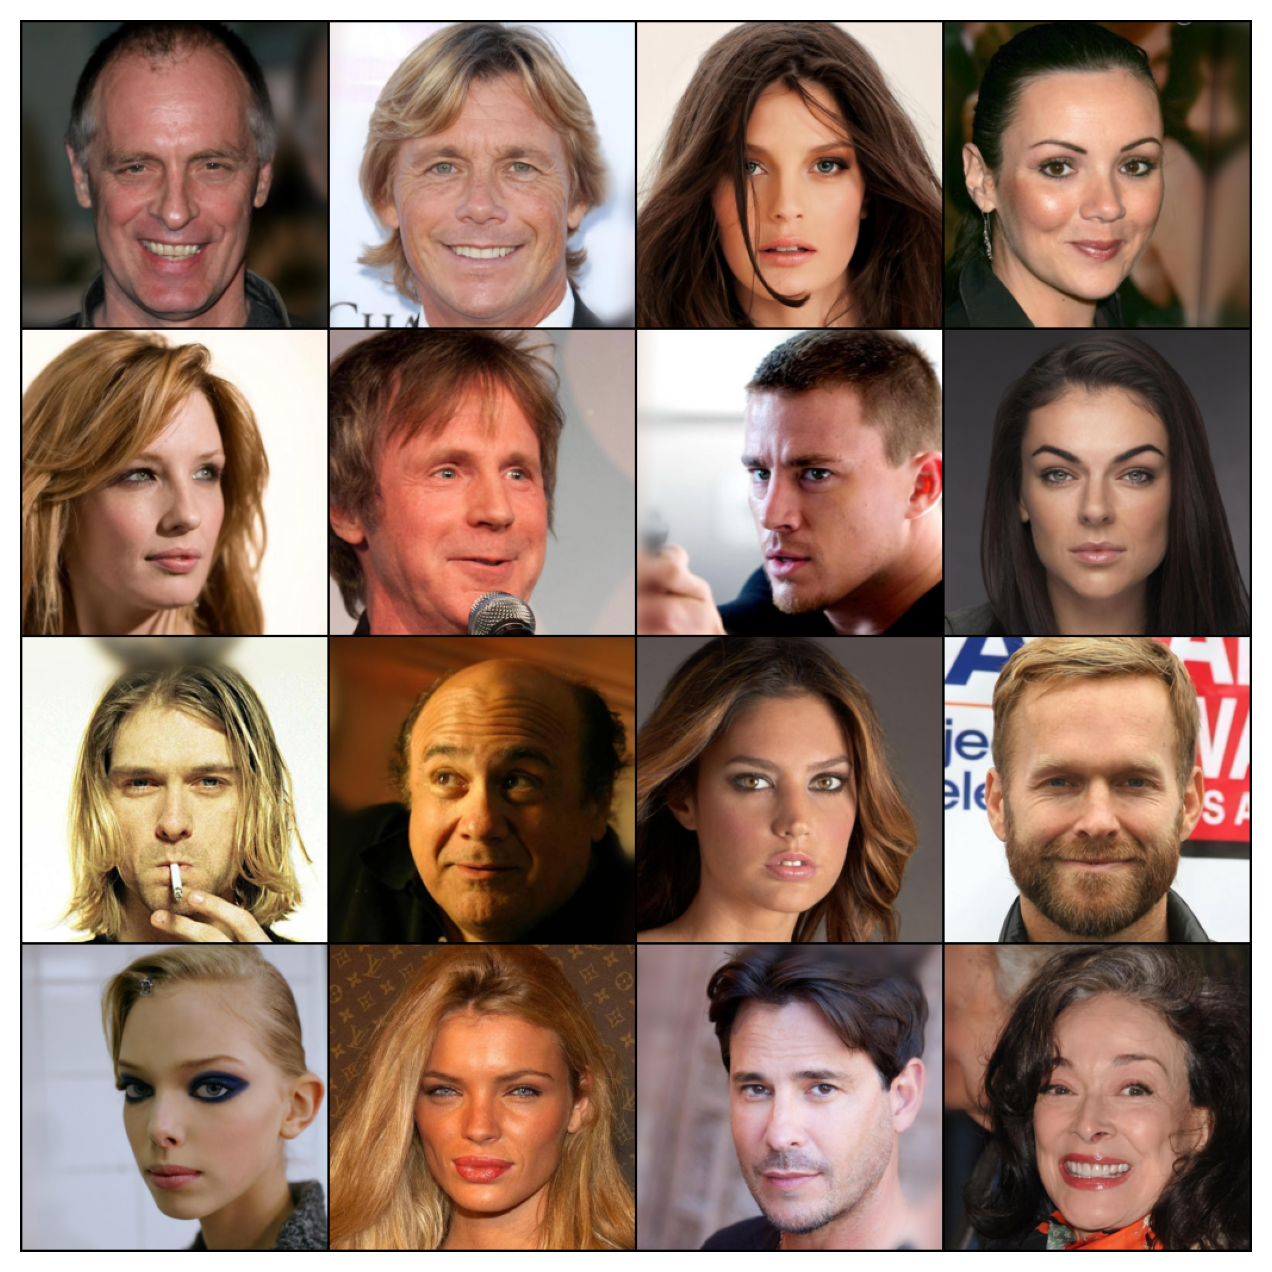

In [46]:
indices = np.random.choice(30000, 16, replace = False)
images = torch.stack([im_dataset[i] for i in indices], dim = 0)
grid = vutils.make_grid(images, nrow = 4, normalize = True)
plt.figure(figsize = (8, 8))
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.axis('off')
plt.show()

## Training of AutoEncoder

100%|██████████| 3750/3750 [16:47<00:00,  3.72it/s]


Finished epoch: 1 | Recon Loss : 0.0397 | Perceptual Loss : -0.0111 | Codebook : 0.0033


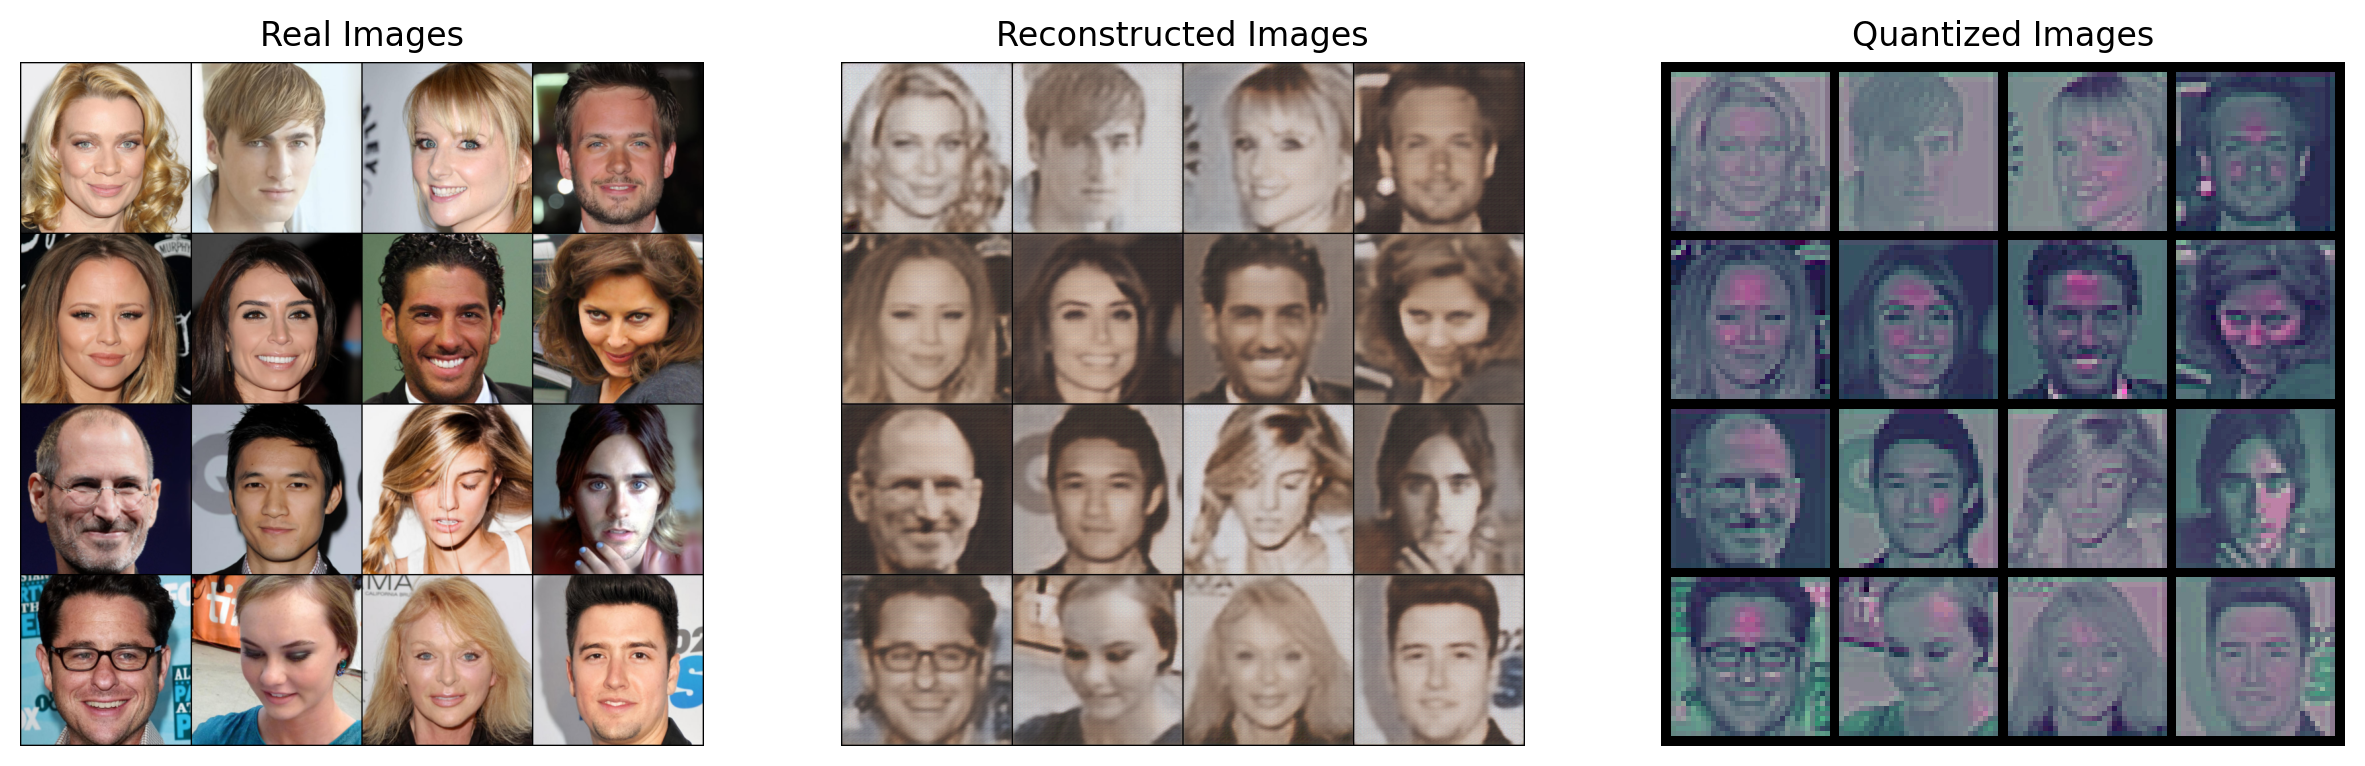

  0%|          | 0/3750 [00:00<?, ?it/s]


RuntimeError: expand(torch.cuda.FloatTensor{[8, 3, 256, 256]}, size=[3, 256, 256]): the number of sizes provided (3) must be greater or equal to the number of dimensions in the tensor (4)

In [47]:
model = VQVAE().to(device)
lpips_model = LPIPS().eval().to(device)
discriminator = Discriminator().to(device)

recon_criterion = nn.MSELoss()
disc_criterion = nn.BCEWithLogitsLoss()

optimizer_d = torch.optim.Adam(discriminator.parameters(), lr = 1e-5, betas = (0.5, 0.999))
optimizer_g = torch.optim.Adam(model.parameters(), lr = 1e-5, betas = (0.5, 0.999))

disc_step_start = 15000
step_count = 0
acc_steps = 4

real_images = [None, None]
reconstructed_images = [None, None]
quantized_images = [None, None]

for epoch_idx in range(num_epochs_autoenc):
    recon_losses = []
    codebook_losses = []
    perceptual_losses = []
    disc_losses = []
    gen_losses = []
    losses = []
    
    optimizer_d.zero_grad()
    optimizer_g.zero_grad()
    
    for batch_idx, im in enumerate(tqdm(celebALoader)):
        
        step_count += 1
        im = im.float().to(device)
        
        # Generator
        model_output = model(im)
        output, z, quantize_losses = model_output
        
        recon_loss = recon_criterion(output, im)
        recon_losses.append(recon_loss.item())
        recon_loss = recon_loss / acc_steps
        
        g_loss = recon_loss + (1 * quantize_losses["codebook_loss"] / acc_steps) + (0.2 * quantize_losses["commitment_loss"] / acc_steps)
        
        codebook_losses.append(quantize_losses["codebook_loss"].item())
        
        # Adversarial Loss
        if step_count > disc_step_start:
            disc_fake_pred = discriminator(output)
            disc_fake_loss = disc_criterion(disc_fake_pred, torch.ones(disc_fake_pred.shape, device = disc_fake_pred.device))
            gen_losses.append(0.5 * disc_fake_loss.item())
            g_loss += 0.5 * disc_fake_loss.item()
        
        lpips_loss = torch.mean(lpips_model(output, im)) / acc_steps
        perceptual_losses.append(lpips_loss.item())
        g_loss += lpips_loss / acc_steps
        losses.append(g_loss.item())
        g_loss.backward()
        optimizer_g.step()
        
        # Discriminator
        if step_count > disc_step_start:
            fake = output
            disc_fake_pred = discriminator(fake.detach())
            disc_real_pred = discriminator(im)
            disc_fake_loss = disc_criterion(disc_fake_pred, torch.zeros(disc_fake_pred.shape, device = disc_fake_pred.device))
            disc_real_loss = disc_criterion(disc_real_pred, torch.ones(disc_real_pred.shape, device = disc_real_pred.device))
            
            disc_loss = 0.5 * (disc_fake_loss + disc_real_loss) / 2
            disc_losses.append(disc_loss.item())
            disc_loss = disc_loss / acc_steps
            disc_loss.backward()
            if step_count % acc_steps == 0:
                optimizer_d.step()
                optimizer_d.zero_grad()
        
        if step_count % acc_steps == 0:
            optimizer_g.step()
            optimizer_g.zero_grad()
        
        idx = batch_idx % 2
        real_images[idx] = im
        reconstructed_images[idx] = output
        quantized_images[idx] = z
    
    optimizer_d.step()
    optimizer_d.zero_grad()
    optimizer_g.step()
    optimizer_g.zero_grad()
    
    
    if len(disc_losses) > 0:
        print(
            'Finished epoch: {} | Recon Loss : {:.4f} | Perceptual Loss : {:.4f} | '
            'Codebook : {:.4f} | G Loss : {:.4f} | D Loss {:.4f}'.
            format(epoch_idx + 1,
                    np.mean(recon_losses),
                    np.mean(perceptual_losses),
                    np.mean(codebook_losses),
                    np.mean(gen_losses),
                    np.mean(disc_losses)))
    else:
        print('Finished epoch: {} | Recon Loss : {:.4f} | Perceptual Loss : {:.4f} | Codebook : {:.4f}'.
                format(epoch_idx + 1,
                        np.mean(recon_losses),
                        np.mean(perceptual_losses),
                        np.mean(codebook_losses)))
        
    torch.save(model.state_dict(), "../vqvaeCeleb/vqvae_autoencoder.pth")
    torch.save(discriminator.state_dict(), "../vqvaeCeleb/vqvae_discriminator.pth")
    
    with torch.no_grad():
        real_images1 = torch.cat(real_images, dim=0)
        reconstructed_images1 = torch.cat(reconstructed_images, dim=0)
        quantized_images1 = torch.cat(quantized_images, dim=0)
        # Each of these lists have 2 tensors of shape (8, 3, 256, 256)
        # So stacking them gives (16, 3, 256, 256)
        # and we plot it in a grid of 4x4
        
        grid_real = vutils.make_grid(real_images1, nrow = 4, normalize = True)
        grid_reconstructed = vutils.make_grid(reconstructed_images1, nrow = 4, normalize = True)
        grid_quantized = vutils.make_grid(quantized_images1, nrow = 4, normalize = True)
        
        plt.figure(figsize = (15, 15))
        plt.subplot(1, 3, 1)
        plt.axis("off")
        plt.title("Real Images")
        plt.imshow(np.transpose(grid_real.cpu().detach().numpy(), (1, 2, 0)))
        
        plt.subplot(1, 3, 2)
        plt.axis("off")
        plt.title("Reconstructed Images")
        plt.imshow(np.transpose(grid_reconstructed.cpu().detach().numpy(), (1, 2, 0)))
        
        plt.subplot(1, 3, 3)
        plt.axis("off")
        plt.title("Quantized Images")
        plt.imshow(np.transpose(grid_quantized.cpu().detach().numpy(), (1, 2, 0)))
        
        plt.show()

# Infer from VQVAE to get latents

In [ ]:
im_dataset = CelebDataset(split='train',
                                im_path=path,
                                im_size=image_size,
                                im_channels=nc)
data_loader = DataLoader(im_dataset,
                            batch_size=1,
                            shuffle=False)

num_images = 1
ngrid = 1

idxs = torch.randint(0, len(im_dataset) - 1, (num_images,))
ims = torch.cat([im_dataset[idx][None, :] for idx in idxs]).float()
ims = ims.to(device)

model = VQVAE().to(device)
model.load_state_dict(torch.load("../vqvaeCeleb/vqvae_autoencoder.pth", map_location = device))
model.eval()

with torch.no_grad():
    
    encoded_output, _ = model.encode(ims)
    decoded_output = model.decode(encoded_output)
    encoded_output = torch.clamp(encoded_output, -1., 1.)
    encoded_output = (encoded_output + 1) / 2
    decoded_output = torch.clamp(decoded_output, -1., 1.)
    decoded_output = (decoded_output + 1) / 2
    ims = (ims + 1) / 2

    encoder_grid = vutils.make_grid(encoded_output.cpu(), nrow=ngrid)
    decoder_grid = vutils.make_grid(decoded_output.cpu(), nrow=ngrid)
    input_grid = vutils.make_grid(ims.cpu(), nrow=ngrid)
    encoder_grid = transforms.ToPILImage()(encoder_grid)
    decoder_grid = transforms.ToPILImage()(decoder_grid)
    input_grid = transforms.ToPILImage()(input_grid)
    
    input_grid.save('../CelebAHQ/input_samples.png')
    encoder_grid.save('../CelebAHQ/encoded_samples.png')
    decoder_grid.save("../CelebAHQ/reconstructed_samples.png")
    
    latent_path = "../vqvaelatents"
    latent_fnames = glob.glob(os.path.join("../vqvaelatents", '*.pkl'))
    assert len(latent_fnames) == 0, 'Latents already present. Delete all latent files and re-run'
    if not os.path.exists(latent_path):
        os.mkdir(latent_path)
    
    fname_latent_map = {}
    part_count = 0
    count = 0
    for idx, im in enumerate(tqdm(data_loader)):
        encoded_output, _ = model.encode(im.float().to(device))
        fname_latent_map[im_dataset.images[idx]] = encoded_output.cpu()
        # Save latents every 1000 images
        if (count+1) % 1000 == 0:
            pickle.dump(fname_latent_map, open(os.path.join(latent_path,
                                                            '{}.pkl'.format(part_count)), 'wb'))
            part_count += 1
            fname_latent_map = {}
        count += 1
    if len(fname_latent_map) > 0:
        pickle.dump(fname_latent_map, open(os.path.join(latent_path,
                                            '{}.pkl'.format(part_count)), 'wb'))
    print("Done saving latents")

## Latent Diffusion Model Architecture
### UNet

In [13]:
class Unet(nn.Module):
    def __init__(self, im_channels = 3):
        super().__init__()
        self.down_channels = [256, 384, 512, 768]
        self.mid_channels = [768, 512]
        self.t_emb_dim = 512
        self.down_sample = [True, True, True]
        self.num_down_layers = 2
        self.num_mid_layers = 2
        self.num_up_layers = 2
        self.attns = [True, True, True]
        self.norm_channels = 32
        self.num_heads = 16
        self.conv_out_channels = 128
        
        # Initial projection from sinusoidal time embedding
        
        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
            nn.SiLU(),
            nn.Linear(self.t_emb_dim, self.t_emb_dim)
        )
        
        self.up_sample = list(reversed(self.down_sample))
        self.conv_in = nn.Conv2d(im_channels, self.down_channels[0], kernel_size = 3, padding = 1)
        
        self.downs = nn.ModuleList([])
        for i in range(len(self.down_channels) - 1):
            self.downs.append(DownBlock(self.down_channels[i], self.down_channels[i + 1],
                                       t_emb_dim = self.t_emb_dim, down_sample = self.down_sample[i],
                                       num_heads = self.num_heads, num_layers = self.num_down_layers,
                                       attn = self.attns[i], norm_channels = self.norm_channels))
        
        self.mids = nn.ModuleList([])
        for i in range(len(self.mid_channels) - 1):
            self.mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i + 1],
                                    t_emb_dim = self.t_emb_dim, num_heads = self.num_heads,
                                    num_layers = self.num_mid_layers, norm_channels = self.norm_channels))
        
        self.ups = nn.ModuleList([])
        for i in reversed(range(len(self.down_channels) - 1)):
            self.ups.append(UpBlockUnet(self.down_channels[i] * 2, self.down_channels[i - 1] if i != 0 else self.conv_out_channels,
                                    self.t_emb_dim, up_sample = self.down_sample[i],
                                        num_heads = self.num_heads,
                                        num_layers = self.num_up_layers,
                                        norm_channels = self.norm_channels))
        
        self.norm_out = nn.GroupNorm(self.norm_channels, self.conv_out_channels)
        self.conv_out = nn.Conv2d(self.conv_out_channels, im_channels, kernel_size = 3, padding = 1)
        
    def forward(self, x, t):
        # Shapes assuming downblocks are [C1, C2, C3, C4]
        # Shapes assuming midblocks are [C4, C4, C3]
        # Shapes assuming downsamples are [True, True, False]
        # B x C x H x W
        out = self.conv_in(x)
        # B x C1 x H x W
        
        # t_emb -> B x t_emb_dim
        t_emb = get_time_embedding(torch.as_tensor(t).long(), self.t_emb_dim)
        t_emb = self.t_proj(t_emb)
        
        down_outs = []
        
        for idx, down in enumerate(self.downs):
            down_outs.append(out)
            out = down(out, t_emb)
        # down_outs  [B x C1 x H x W, B x C2 x H/2 x W/2, B x C3 x H/4 x W/4]
        # out B x C4 x H/4 x W/4
        
        for mid in self.mids:
            out = mid(out, t_emb)
        # out B x C3 x H/4 x W/4
        
        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb)
            # out [B x C2 x H/4 x W/4, B x C1 x H/2 x W/2, B x 16 x H x W]
        out = self.norm_out(out)
        out = nn.SiLU()(out)
        out = self.conv_out(out)
        # out B x C x H x W
        return out

### Linear Noise Scheduler

In [14]:
class LinearNoiseScheduler:
    r"""
    Class for the linear noise scheduler that is used in DDPM.
    """
    
    def __init__(self, num_timesteps, beta_start, beta_end):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        # Mimicking how compvis repo creates schedule
        self.betas = (
                torch.linspace(beta_start ** 0.5, beta_end ** 0.5, num_timesteps) ** 2
        )
        self.alphas = 1. - self.betas
        self.alpha_cum_prod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_cum_prod = torch.sqrt(self.alpha_cum_prod)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - self.alpha_cum_prod)
    
    def add_noise(self, original, noise, t):
        r"""
        Forward method for diffusion
        :param original: Image on which noise is to be applied
        :param noise: Random Noise Tensor (from normal dist)
        :param t: timestep of the forward process of shape -> (B,)
        :return:
        """
        original_shape = original.shape
        batch_size = original_shape[0]
        
        sqrt_alpha_cum_prod = self.sqrt_alpha_cum_prod.to(original.device)[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod.to(original.device)[t].reshape(batch_size)
        
        # Reshape till (B,) becomes (B,1,1,1) if image is (B,C,H,W)
        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
        for _ in range(len(original_shape) - 1):
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)
        
        # Apply and Return Forward process equation
        return (sqrt_alpha_cum_prod.to(original.device) * original
                + sqrt_one_minus_alpha_cum_prod.to(original.device) * noise)
    
    def sample_prev_timestep(self, xt, noise_pred, t):
        r"""
            Use the noise prediction by model to get
            xt-1 using xt and the nosie predicted
        :param xt: current timestep sample
        :param noise_pred: model noise prediction
        :param t: current timestep we are at
        :return:
        """
        x0 = ((xt - (self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t] * noise_pred)) /
              torch.sqrt(self.alpha_cum_prod.to(xt.device)[t]))
        x0 = torch.clamp(x0, -1., 1.)
        
        mean = xt - ((self.betas.to(xt.device)[t]) * noise_pred) / (self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t])
        mean = mean / torch.sqrt(self.alphas.to(xt.device)[t])
        
        if t == 0:
            return mean, x0
        else:
            variance = (1 - self.alpha_cum_prod.to(xt.device)[t - 1]) / (1.0 - self.alpha_cum_prod.to(xt.device)[t])
            variance = variance * self.betas.to(xt.device)[t]
            sigma = variance ** 0.5
            z = torch.randn(xt.shape).to(xt.device)
            
            # OR
            # variance = self.betas[t]
            # sigma = variance ** 0.5
            # z = torch.randn(xt.shape).to(xt.device)
            return mean + sigma * z, x0

## Latent Diffusion Model Training

In [17]:
# Train Parameters
lr = 5e-5

# Diffusion Parameters
beta_start = 1e-4
beta_end = 2e-2
T = 1000

# Model Parameters
nc = 3
image_size = 256
z_channels = 3

## Use Latents for setting up the data

In [ ]:
im_dataset = CelebDataset(split='train',
                                im_path=path,
                                im_size=image_size,
                                im_channels=nc,
                                use_latents=True,
                                latent_path="../vqvaelatents"
                                )
    
celebALoader = DataLoader(im_dataset,
                            batch_size=batch_size_ldm,
                            shuffle=True)

In [ ]:
scheduler = LinearNoiseScheduler(num_timesteps = T, beta_start = beta_start, beta_end = beta_end)

model = Unet(im_channels = z_channels).to(device)
model.train()

if not im_dataset.use_latents:
    vae = VQVAE().to(device)
    vae.eval()
    vae.load_state_dict(torch.load("../vqvaeCeleb/vqvae_autoencoder.pth", map_location = device))

if not im_dataset.use_latents:
    for param in vae.parameters():
        param.requires_grad = False
    
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = nn.MSELoss()

for epoch_idx in range(num_epochs_ldm):
    losses = []
    for i, (im, _) in enumerate(celebALoader):
        optimizer.zero_grad()
        im = im.float().to(device)
        
        # THE MAIN PART -> LATENT SPACE TRAINING
        if not im_dataset.use_latents:
            with torch.no_grad():
                im, _ = vae.encode(im)
        
        noise = torch.randn_like(im).to(device)
        t = torch.randint(0, T, (im.shape[0],)).to(device)
        
        noisy_im = scheduler.add_noise(im, noise, t)
        noise_pred = model(noisy_im, t)
        
        loss = criterion(noise_pred, noise)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch_idx + 1}/{num_epochs_ldm}], Loss: {np.mean(losses)}")
    torch.save(model.state_dict(), "../ldmCeleb/denoiseLatentModelCeleb.pth")

## Sampling

In [19]:
num_grid_rows = 4
num_samples = 16

In [ ]:
scheduler = LinearNoiseScheduler(T, beta_start, beta_end)

model = Unet(im_channels = z_channels).to(device)
model.load_state_dict(torch.load("../ldmCeleb/denoiseLatentModelCeleb.pth", map_location = device))
model.eval()

vae = VQVAE().to(device)
vae.eval()
vae.load_state_dict(torch.load("../vqvaeCeleb/vqvae_autoencoder.pth", map_location=device), strict=True)

with torch.no_grad():
    im_size = image_size // (2 ** (sum(model.down_sample)))
    xt = torch.randn((num_samples, z_channels, im_size, im_size)).to(device)

    for t in reversed(range(T)):
        noise_pred = model(xt, torch.as_tensor(t).unsqueeze(0).to(device))
        xt, x0_pred = scheduler.sample_prev_timestep(xt, noise_pred, torch.as_tensor(t).to(device))
        
        ims_raw = torch.clamp(xt, -1., 1.).detach().cpu()
        ims_raw = (ims_raw + 1) / 2
        
        ims = vae.decode(xt)
        ims = torch.clamp(ims, -1., 1.).detach().cpu()
        ims = (ims + 1) / 2
        
        grid_latent = vutils.make_grid(ims_raw, nrow = num_grid_rows, normalize = True)
        grid_reconstructed = vutils.make_grid(ims, nrow = num_grid_rows, normalize = True)
        
        if (t % 50 == 0):
            plt.figure(figsize = (15, 15))
            plt.subplot(1, 2, 1)
            plt.axis("off")
            plt.imshow(np.transpose(grid_latent.cpu().detach().numpy(), (1, 2, 0)))
            
            plt.subplot(1, 2, 2)
            plt.axis("off")
            plt.imshow(np.transpose(grid_reconstructed.cpu().detach().numpy(), (1, 2, 0)))
            
            plt.show()
            
        img_latent = transforms.ToPILImage()(grid_latent)
        img_decode = transforms.ToPILImage()(grid_reconstructed)
        if not os.path.exists("./DDPM/CelebLatent"):
            os.makedirs("./DDPM/CelebLatent")
            
        if not os.path.exists("../DDPM/CelebDecode"):
            os.makedirs("../DDPM/CelebDecode")
        

        img_latent.save(f"../DDPM/CelebLatent/x0_{t}.png")
        img_latent.close()
        
        img_decode.save(f"../DDPM/CelebDecode/x0_{t}.png")
        img_decode.close()